# COMP5329 - Deep Learning
## Assignment 2 - Multilabel Classification

*   Nirav Desai
*   Rebecca Chan



## Initial Set up
### Load packages

In [ ]:
## Load libraries
import re, os
import pandas as pd
from io import StringIO
from google.colab import drive

%matplotlib inline
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import time
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import itertools
import os
import pandas as pd
import seaborn as sns

from torchvision import datasets, transforms
from torch.utils.data import Dataset
from sklearn.metrics import confusion_matrix
from datetime import timedelta
from torch import optim
import torchvision.models as models
from sklearn.metrics import classification_report, multilabel_confusion_matrix, coverage_error


torch.__version__

'1.8.1+cu101'

##### Use GPU if available

In [ ]:
use_cuda = True if torch.cuda.is_available() else False
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('We are using GPU.' if use_cuda else 'We are using CPU.')



We are using GPU.


##### Mount google drive

In [ ]:
drive.mount('/content/gdrives')
data_path = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g5Ataz-mVsm-1t1lkMxh6fJQ-94dhwpEPTmA1FtvIaSgIvmKyieiNw
Mounted at /content/gdrives


In [ ]:
train_set = '/content/gdrives/MyDrive/COMP5329/COMP5329S1A2Dataset/train.csv'
with open(train_set) as train: 
  lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
  df_train = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

df_train.head()


,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Load Dataset Function

**Inputs:**
  1. Root Directory for Images
  2. csv filename with annotations
  3. Pytorch transform object

**Outputs:**
  - Training and Validation Set
    - tuple with image as a tensor and corresponding target One-Hot encoded label as tensor (image, label)
  - Test Set
    - image as a tensor

In [ ]:
class load_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        with open(root_dir+'/'+annotation_file) as train: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in train]
          train_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')

        self.root_dir = root_dir
        self.annotations = train_labels
        self.transform = transform


    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index, 0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")
        split_label = self.annotations.iloc[index, 1].split()
        num_labels = list(map(int, split_label))
        label = torch.LongTensor(num_labels) - 1
        one_hot_labels = torch.zeros(size=([19]), dtype=torch.float32)
        # print(label, self.one_hot_labels.shape, label.shape)
        y_label = one_hot_labels.scatter_(dim=0, index=label, value=1.)
        # y_label = torch.tensor(float(self.annotations.iloc[index, 1]))

        if self.transform is not None:
            img = self.transform(img)

        return (img, y_label)

In [ ]:
# For TEST data

class load_test_data(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None): 
        with open(root_dir + '/' + annotation_file) as test: 
          lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in test]
          test_labels = pd.read_csv(StringIO(''.join(lines)), escapechar="/", encoding='utf-8')    

        self.root_dir = root_dir
        self.annotations = test_labels
        self.transform = transform
      
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_id = self.annotations.iloc[index,0]
        img = Image.open(os.path.join(self.root_dir+'/data', img_id)).convert("RGB")

        if self.transform is not None: 
            img = self.transform(img)

        return (img)

## Image Pre-processing and Augmentation

- Augmentation Techniues such as:
  - Crop
  - Resize
  - Flipping (Horizontal and Vertical)
  - Rotation
  - Brightness Changes
- Normalize
- Load raw data and split into Training and Validation
- Create pytorch DataLoader instance for Train, Validation and Test set

In [ ]:
# https://stackoverflow.com/questions/56774582/adding-custom-labels-to-pytorch-dataloader-dataset-does-not-work-for-custom-data (for adding labels)
# https://medium.com/analytics-vidhya/implementing-cnn-in-pytorch-with-custom-dataset-and-transfer-learning-1864daac14cc (maybe better?)
# https://pytorch.org/tutorials/beginner/basics/data_tutorial.html try this

# DataLoader Parameters
kwargs = {'num_workers': 2, 'pin_memory': True} if use_cuda else {}
kwargs['batch_size'] = 16  # Batch size used during training.
shuffle=True
batch_size = 128 # Images per batch
num_workers = 2
pin_memory = True

# Transform for data pre-processing
transform = transforms.Compose([transforms.Resize(240), 
                                transforms.CenterCrop(224),
                                transforms.ToTensor(), 
                                transforms.Normalize((0.4914, 0.48216, 0.44653), (0.24703, 0.24349, 0.26159))
                                ])

# raw_dataset = load_data(data_path,"train_1100.csv",transform=transform)
# raw_dataset = load_data(data_path,"train_100.csv",transform=transform)
raw_dataset = load_data(data_path,"train.csv",transform=transform)

# Train - Validation split
total_raw_data = len(raw_dataset)
train_valid_split = 0.2 ## Creating a small dataset to work on... (only using 20% of samples as training until model is finalised)
valid_record_size = int(train_valid_split * total_raw_data)
train_record_size = int(total_raw_data - valid_record_size)
print(train_record_size, valid_record_size)

train_set, validation_set = torch.utils.data.random_split(raw_dataset, [train_record_size,valid_record_size])

train_loader = torch.utils.data.DataLoader(dataset=train_set, 
                                           shuffle=shuffle, 
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           pin_memory=pin_memory)

validation_loader = torch.utils.data.DataLoader(dataset=validation_set, 
                                                shuffle=shuffle, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

print('Dataloaders initialized.')

images, labels = next(iter(train_loader))
_, _ = next(iter(validation_loader))

print('Shape of an image batch:', images.size())

# Should be approx. 40,000 images (30,000 for training, 10,000 for testing)
print('No. images loaded: ',len(train_loader)*batch_size)


23997 5999
Dataloaders initialized.
Shape of an image batch: torch.Size([128, 3, 224, 224])
No. images loaded:  24064


In [ ]:
# print a batch of labels
print(labels.size())

torch.Size([128, 19])


## Exploratory Dataset Analysis

#### Training Labels

In [ ]:
a = raw_dataset.annotations['Labels'][train_set.indices]
type(a)
b=a.str.split()
c=b.explode().value_counts()
c.index = c.index.astype(int)
print(type(c))
# print(a[1], b[1])
d = c.sort_index()
print(d)
e = d.to_numpy()
print(e)
# f = np.insert(e,8,0) # for missing label 9, inserting 0
f = np.insert(e,11,0) # for missing label 12, inserting 0
print(f, len(f))


<class 'pandas.core.series.Series'>
1     18273
2       932
3      3496
4      1011
5       922
6      1116
7       990
8      1765
9       852
10     1167
11      477
13      496
14      204
15     1578
16      876
17     1108
18     1226
19      809
Name: Labels, dtype: int64
[18273   932  3496  1011   922  1116   990  1765   852  1167   477   496
   204  1578   876  1108  1226   809]
[18273   932  3496  1011   922  1116   990  1765   852  1167   477     0
   496   204  1578   876  1108  1226   809] 19


#### Weight calculation per sample class

In [ ]:
class_counts = f
num_samples = sum(class_counts)


class_weights = [num_samples/class_counts[i] for i in range(len(class_counts))]
# weights = [class_weights[labels_temp[i]] for i in range(int(num_samples))]
# class_weights[8] = 0
class_weights[11] = 0
print(type(class_weights),class_weights)
smp = np.array(class_weights)
print(type(smp),smp)
sss = torch.from_numpy(smp).float().to(dev)
print(type(sss),sss)


<class 'list'> [2.0411536146226674, 40.01931330472103, 10.668764302059497, 36.8921859545005, 40.453362255965295, 33.42114695340502, 37.67474747474748, 21.132011331444758, 43.77699530516432, 31.960582690659812, 78.19287211740041, 0, 75.1975806451613, 182.83333333333334, 23.636248415716096, 42.577625570776256, 33.66245487364621, 30.42251223491028, 46.103831891223734]
<class 'numpy.ndarray'> [  2.04115361  40.0193133   10.6687643   36.89218595  40.45336226
  33.42114695  37.67474747  21.13201133  43.77699531  31.96058269
  78.19287212   0.          75.19758065 182.83333333  23.63624842
  42.57762557  33.66245487  30.42251223  46.10383189]
<class 'torch.Tensor'> tensor([  2.0412,  40.0193,  10.6688,  36.8922,  40.4534,  33.4211,  37.6747,
         21.1320,  43.7770,  31.9606,  78.1929,   0.0000,  75.1976, 182.8333,
         23.6362,  42.5776,  33.6625,  30.4225,  46.1038], device='cuda:0')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in long_scalars
  """


#### Training Label Distribution

<BarContainer object of 19 artists>

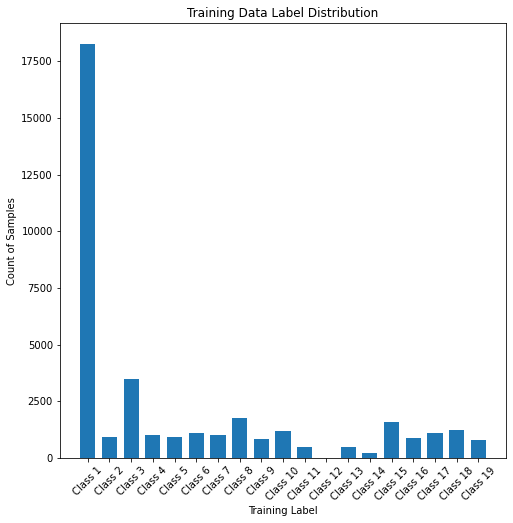

In [ ]:
%matplotlib inline
class_labels = ['Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9', 'Class 10', 'Class 11', 'Class 12', 'Class 13', 'Class 14', 'Class 15', 
'Class 16', 'Class 17', 'Class 18','Class 19']
plt.rcParams['figure.figsize'] = [8, 8]
plt.title('Training Data Label Distribution')
plt.ylabel('Count of Samples')
plt.xlabel('Training Label')
plt.xticks(np.arange(0,19,1), class_labels, rotation=45)
plt.bar(np.arange(len(class_counts)),class_counts, width=0.7)


In [ ]:
def calc_label_weights(n_classes, samples_classes, pw=1):
    label_weightage = 1.0 / np.array(np.power(samples_classes, pw))
    label_weightage = label_weightage / np.sum(label_weightage) * n_classes
    return label_weightage



#### Display Sample Images after Pre-processing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 0
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0.])


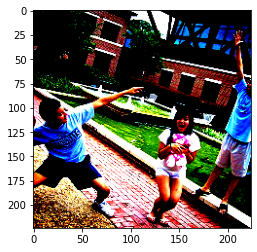

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 1
image label : tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0.])


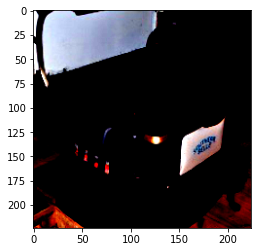

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 2
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


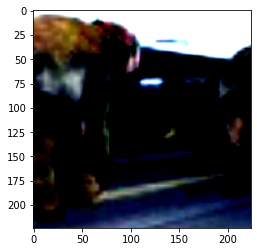

index : 3
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0.])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


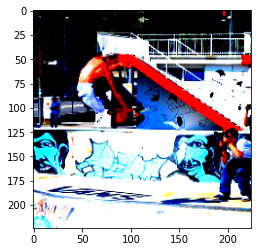

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


index : 4
image label : tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0.])


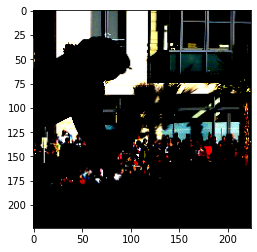

done!


In [ ]:
## Reconstruct some images -- note: images have been normalised 
for i in range(5):
    print('index : {}'.format(i))
    print('image label : {}'.format(labels[i]))
    npimg = images[i].numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

print('done!')

In [ ]:
# # calculate top-k accuracy (??? from tutorial code)
# def accuracy(output, target, topk=(1,)):
#     maxk = max(topk)
#     batch_size = target.size(0)

#     _, pred = output.topk(maxk, 1, True, True)
#     pred = pred.t()
#     correct = pred.eq(target.view(1, -1).expand_as(pred))

#     res = []
#     for k in topk:
#         correct_k = correct[:k].view(-1).float().sum(0)
#         res.append(correct_k.mul_(100.0/batch_size))
#     return res

## Modelling stage:

##### Pre-trained Resnext50_32X4d

In [ ]:
# Implement a simple NN for testing 

class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))



##### Removing gradients for re-training and ignoring pre-trained gradients

In [ ]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

# Implement a simple NN for testing 
feature_extract = True

#### Create pre-trained DenseNet (121)

In [ ]:
# Implement a simple NN for testing 

class Dense161(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        densenet = models.densenet121(pretrained=True)
        densenet.classifier = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=densenet.classifier.in_features, out_features=n_classes)
        )
        self.base_model = densenet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

# model = Dense161(19).to(dev)

#### Create pre-trained ResNet50

In [ ]:
class Resnet50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        set_parameter_requires_grad(resnet, feature_extract)
        resnet.fc = nn.Sequential(
            # nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))
        # return self.base_model(x)

# Initialize Base Model
model = Resnet50(19).to(dev)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


##### Set parameters to update and Optimizer

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
    params_to_update = []
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

summary(model.cuda(), (1,3, 224, 224))

Params to learn:
	 base_model.fc.0.weight
	 base_model.fc.0.bias


Layer (type:depth-idx)                        Output Shape              Param #
Resnet50                                      --                        --
├─ResNet: 1-1                                 [1, 19]                   --
│    └─Conv2d: 2-1                            [1, 64, 112, 112]         (9,408)
│    └─BatchNorm2d: 2-2                       [1, 64, 112, 112]         (128)
│    └─ReLU: 2-3                              [1, 64, 112, 112]         --
│    └─MaxPool2d: 2-4                         [1, 64, 56, 56]           --
│    └─Sequential: 2-5                        [1, 256, 56, 56]          --
│    │    └─Bottleneck: 3-1                   [1, 256, 56, 56]          (75,008)
│    │    └─Bottleneck: 3-2                   [1, 256, 56, 56]          (70,400)
│    │    └─Bottleneck: 3-3                   [1, 256, 56, 56]          (70,400)
│    └─Sequential: 2-6                        [1, 512, 28, 28]          --
│    │    └─Bottleneck: 3-4                   [1, 512, 28, 28]       

In [ ]:
def accuracy(predicted, original):  
    """
    Calculates the number of labels correctly predicted for each image
    """
    return torch.round(predicted).eq(original).sum().numpy()/len(original)

### Model Training with hypermarameters

In [ ]:
# https://pytorch.org/docs/stable/optim.html

# Switch model to the training mode
criterion = nn.BCELoss()
model.train()

no_epochs = 25
## Perform training stage 
for epoch in range(no_epochs): 
  print(f'epoch {epoch + 1}')

  start = time.time()
  ep_loss = 0.0
  ep_acc = 0.0
  
  ## Enumerate through data
  for i, (inputs,labels) in enumerate(train_loader, 0):
    inputs = inputs.to(dev)
    labels = labels.to(dev)

    # Zero the parameter gradients
    optimizer.zero_grad()

    # Forward + backward + optimize
    outputs = model(inputs)
    loss = criterion(outputs.float(), labels.float())

    preds = outputs
    torch.cuda.empty_cache()
    ep_loss += loss
    ep_acc += accuracy(torch.round(preds).cpu(), labels.cpu())

    loss.backward()
    optimizer.step()
  
  print(f'Loss: {ep_loss/(i+1) :.3f}, Accuracy: {ep_acc/(i+1) :.3f}')
  print(f'time taken to run: {time.time() - start}')

epoch 1
Loss: 0.247, Accuracy: 17.604
time taken to run: 2238.1873033046722
epoch 2
Loss: 0.183, Accuracy: 17.969
time taken to run: 119.62403964996338
epoch 3
Loss: 0.175, Accuracy: 17.969
time taken to run: 119.9700825214386
epoch 4
Loss: 0.169, Accuracy: 17.971
time taken to run: 120.65964460372925
epoch 5
Loss: 0.163, Accuracy: 17.982
time taken to run: 120.57134103775024
epoch 6
Loss: 0.158, Accuracy: 17.996
time taken to run: 121.11932611465454
epoch 7
Loss: 0.154, Accuracy: 18.013
time taken to run: 120.54762625694275
epoch 8
Loss: 0.150, Accuracy: 18.028
time taken to run: 121.14209389686584
epoch 9
Loss: 0.146, Accuracy: 18.041
time taken to run: 121.25954794883728
epoch 10
Loss: 0.143, Accuracy: 18.056
time taken to run: 120.76710319519043
epoch 11
Loss: 0.141, Accuracy: 18.072
time taken to run: 121.28546571731567
epoch 12
Loss: 0.138, Accuracy: 18.086
time taken to run: 121.24626088142395
epoch 13
Loss: 0.136, Accuracy: 18.101
time taken to run: 121.77492427825928
epoch 14


In [ ]:
torch.cuda.memory.empty_cache()

### Model Validation on validation set data

In [ ]:
import gc

model.eval()

epoch_loss = 0.0
epoch_accuracy = 0.0
pred_results = np.array(range(1,20)).reshape(1,19)
target_results = np.array(range(1,20)).reshape(1,19)
print(target_results.shape, target_results)

for step, (inputs, label) in enumerate(validation_loader):

    inputs = torch.Tensor.cpu(inputs).to(dev)
    label = torch.Tensor.cpu(label).to(dev)

    y_pred = model(inputs)
    preds_rounded = torch.round(y_pred) #anything greater than prob > 0.5 converted to predicted label
    preds_np = torch.Tensor.cpu(preds_rounded).detach().numpy()
    targets_np = torch.Tensor.cpu(label).detach().numpy()

    pred_results = np.concatenate((pred_results, preds_np), axis=0)
    target_results = np.concatenate((target_results, targets_np), axis=0)

    acc = accuracy(preds_rounded.cpu(), label.cpu())
    torch.cuda.empty_cache()
    
    epoch_loss += criterion(y_pred.float(), label.float())
    epoch_accuracy += acc

print(epoch_loss/(len(validation_loader)))
print(epoch_accuracy/(len(validation_loader)))
print(pred_results.shape, target_results.shape)

(1, 19) [[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]]
tensor(0.1176, device='cuda:0', grad_fn=<DivBackward0>)
18.23357832566609
(6000, 19) (6000, 19)


In [ ]:
class_names = np.array(list(range(1, 20)))

### Model evaluation
- Classification Report
- Confusion Matrix for all classes

In [ ]:
classes = [str(i).zfill(2) for i in range(1,20)]
print(class_names, classes)
print(classification_report(target_results[1:], pred_results[1:], target_names=classes , zero_division=1))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19] ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
              precision    recall  f1-score   support

          01       0.88      0.94      0.91      4521
          02       1.00      0.00      0.00       230
          03       0.69      0.33      0.44       868
          04       0.99      0.39      0.56       261
          05       0.99      0.65      0.78       208
          06       0.96      0.45      0.61       278
          07       0.99      0.55      0.71       231
          08       0.78      0.18      0.30       445
          09       0.92      0.13      0.22       190
          10       0.70      0.18      0.28       304
          11       1.00      0.00      0.00       127
          12       1.00      1.00      1.00         0
          13       1.00      0.01      0.02       109
          14       1.00      0.00      0.00        47
          15   

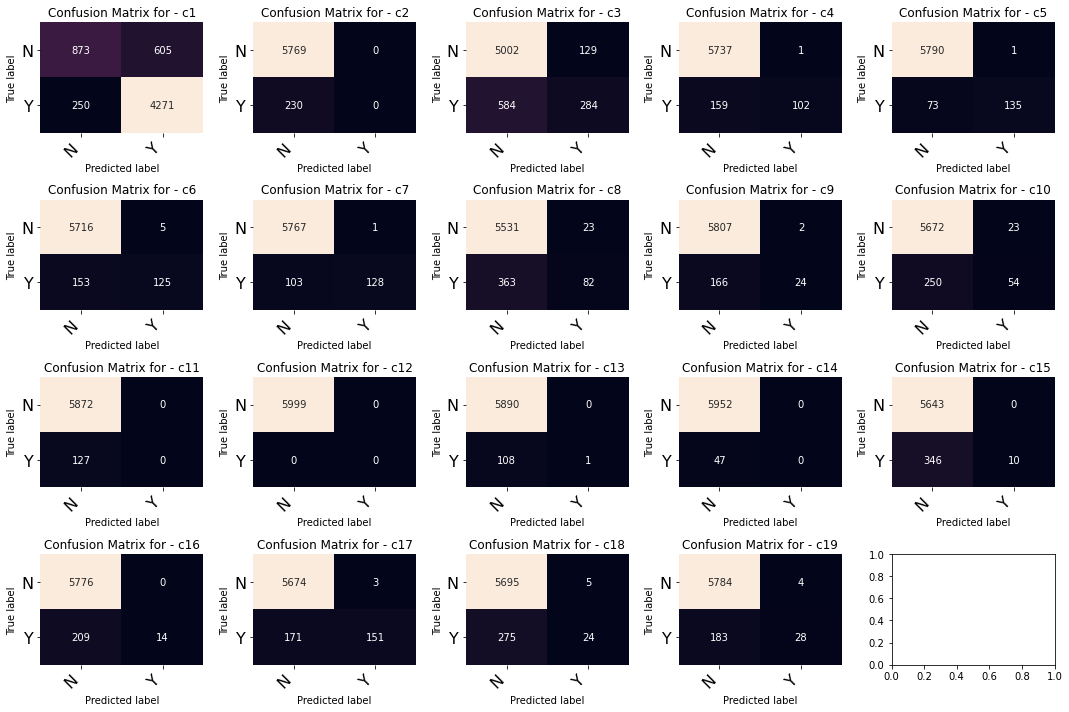

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix, coverage_error
multi_matrix = multilabel_confusion_matrix(target_results[1:], pred_results[1:])


labels = ["".join("c" + str(i)) for i in range(1, 20)]

def display_heatmap(confusion_matrix, axes, class_labels, class_names, fontsize=16):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_ylabel('True label')
    axes.set_xlabel('Predicted label')
    axes.set_title("Confusion Matrix for - " + class_labels)


fig, ax = plt.subplots(4, 5, figsize=(15, 10))
for axes, cfs_matrix, label in zip(ax.flatten(), multi_matrix, labels):
        display_heatmap(cfs_matrix, axes, label, ["N", "Y"])
    
fig.tight_layout()
plt.show()

## Test Prediction
- Initialize test loader
- Run and save predictions

In [ ]:
test_dataset = load_test_data(data_path, "test.csv", transform=transform)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          shuffle = False, 
                                          batch_size = None
                                          )

test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                                shuffle=False, 
                                                batch_size=batch_size,
                                                num_workers=num_workers, 
                                                pin_memory=pin_memory)

test_images = next(iter(test_loader))

print('No. Test images loaded: ',len(test_loader)*batch_size)

No. Test images loaded:  10112


##### Test set - Predict and save results

In [ ]:
## Make test predictions
model.eval()
test_pred_results = np.array(range(1,20)).reshape(1,19)
images = []
predictions = []
cnt=0

for step, (test_inputs) in enumerate(test_loader):
    idx = step*batch_size
    images.append(test_dataset.annotations.ImageID[idx:(idx+batch_size)])
    test_inputs = torch.Tensor.cpu(test_inputs).to(dev)

    y_test = model(test_inputs)

    test_preds_rounded = torch.round(y_test) #anything greater than prob > 0.5 converted to predicted label
    test_preds_np = torch.Tensor.cpu(test_preds_rounded).detach().numpy()
    test_pred_results = np.concatenate((test_pred_results, test_preds_np), axis=0)


test_pred_results = test_pred_results[1:]
for result in test_pred_results:
    result_lb = class_names[result == 1.0] 
    preds_string = [str(int) for int in result_lb]
    predictions.append(' '.join(preds_string))


prediction_upload = pd.DataFrame(zip(test_dataset.annotations.ImageID, predictions), columns = ['ImageID', 'Labels'])
prediction_upload.to_csv(data_path + '/alexnet_test_predictions.csv', index = False)
prediction_upload.head()

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1
